In [68]:
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
users = pd.read_csv('data_design/users.csv', parse_dates = ['signup_date'])
events = pd.read_csv('data_design/events.csv', parse_dates = ['event_time', 'first_seen'])
features = pd.read_csv('data_design/features.csv', parse_dates = ['launch_date'])
calendar_effects = pd.read_csv('data_design/calendar_effects.csv', parse_dates = ['date'])

In [70]:
events["date"] = events["event_time"].dt.date

daily_sessions = events.groupby("date").size()
daily_active_users = events.groupby("date")["user_id"].nunique()

esau = daily_sessions / daily_active_users

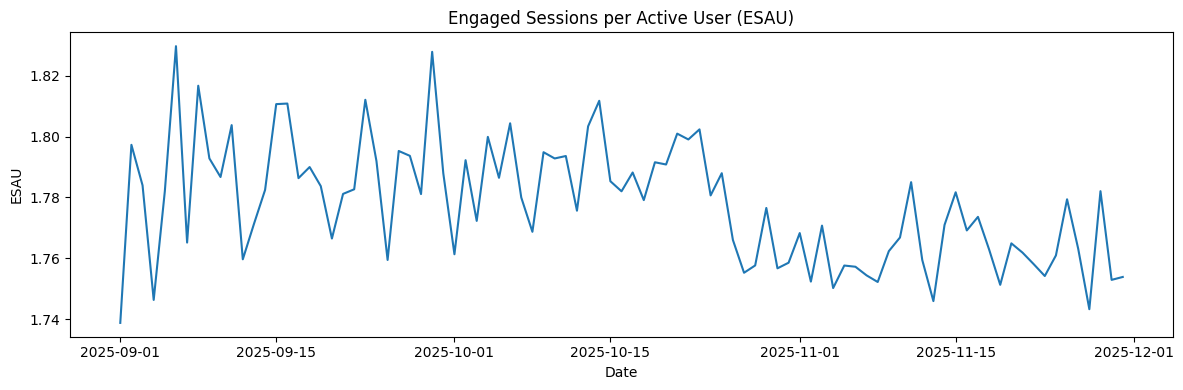

In [71]:
plt.figure(figsize=(12,4))
plt.plot(esau)
plt.title("Engaged Sessions per Active User (ESAU)")
plt.xlabel("Date")
plt.ylabel("ESAU")
plt.tight_layout()
plt.show()


In [72]:
esau.mean()
esau.tail(28).mean()


np.float64(1.7623903329656636)

In [73]:
feature_launch = features.loc[0, "launch_date"].date()

pre_esau = esau[esau.index < feature_launch]
post_esau = esau[esau.index >= feature_launch]

pre_mean = pre_esau.mean()
post_mean = post_esau.mean()

drop_pct = (pre_mean - post_mean) / pre_mean * 100
pre_mean, post_mean, drop_pct


(np.float64(1.7880730748520337),
 np.float64(1.7621798510177635),
 np.float64(1.448107697523094))

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

pre_post_df = pd.DataFrame({
    "Period": ["Pre-Launch", "Post-Launch"],
    "ESAU": [pre_mean, post_mean]
})


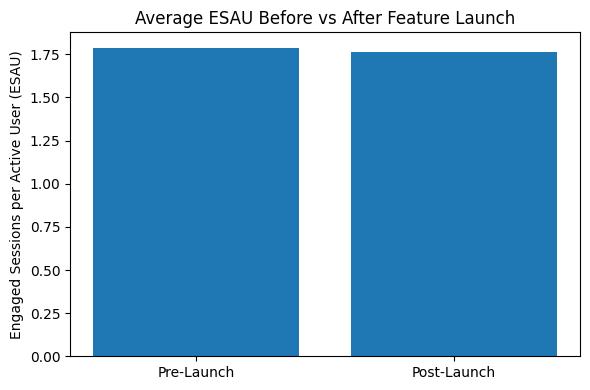

In [100]:
plt.figure(figsize=(6,4))
plt.bar(pre_post_df["Period"], pre_post_df["ESAU"])
plt.title("Average ESAU Before vs After Feature Launch")
plt.ylabel("Engaged Sessions per Active User (ESAU)")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [74]:
events["post"] = (events["date"] >= feature_launch).astype(int)
events["treated"] = events["feature_exposed"]


In [75]:
did_df = (
    events
    .groupby(["date", "treated", "post"])
    .agg(
        sessions=("user_id", "count"),
        active_users=("user_id", "nunique")
    )
    .reset_index()
)

did_df["esau"] = did_df["sessions"] / did_df["active_users"]


In [76]:
import statsmodels.formula.api as smf

did_model = smf.ols(
    "esau ~ treated + post + treated:post",
    data=did_df
).fit()

did_model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7881,0.002,961.140,0.000,1.784,1.792
treated,0.0662,0.002,40.711,0.000,0.063,0.069
post,-0.5039,0.003,-170.353,0.000,-0.510,-0.498
treated:post,0.0662,0.002,40.711,0.000,0.063,0.069


In [77]:
pre_events = events[events["date"] < feature_launch]

user_features = (
    pre_events
    .groupby("user_id")
    .agg(
        pre_sessions=("event_time", "count"),
        pre_active_days=("date", "nunique")
    )
    .reset_index()
)


In [78]:
user_features = user_features.merge(users, on="user_id")


In [79]:
treated_users = (
    events.query("post == 1 and feature_exposed == 1")["user_id"]
    .unique()
)

user_features["treated"] = user_features["user_id"].isin(treated_users).astype(int)


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = user_features[["pre_sessions", "pre_active_days"]]
y = user_features["treated"]

psm = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000))
])

psm.fit(X, y)
user_features["propensity"] = psm.predict_proba(X)[:,1]


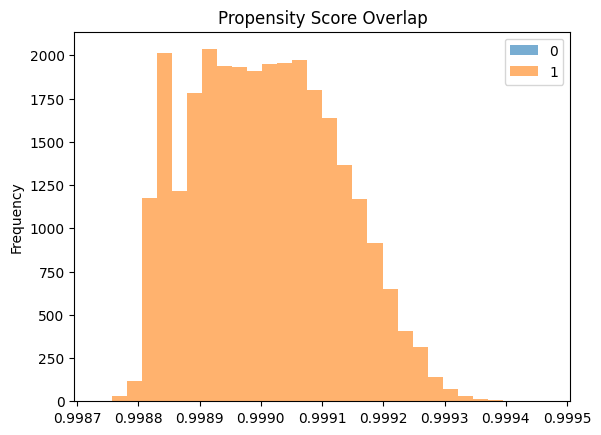

In [81]:
user_features.groupby("treated")["propensity"].plot(
    kind="hist",
    bins=30,
    alpha=0.6,
    legend=True,
    title="Propensity Score Overlap"
)
plt.show()


In [82]:
treated = user_features[user_features["treated"] == 1]
control = user_features[user_features["treated"] == 0]

control_matched = control.iloc[
    (control["propensity"].values[:,None] -
     treated["propensity"].values).argmin(axis=0)
]

matched_users = pd.concat([treated, control_matched])


In [83]:
matched_events = events.merge(
    matched_users[["user_id", "treated"]],
    on="user_id",
    how="inner"
)

def daily_esau(df):
    return (
        df.groupby("date").size() /
        df.groupby("date")["user_id"].nunique()
    )

esau_treated = daily_esau(matched_events[matched_events["treated_x"] == 1])
esau_control = daily_esau(matched_events[matched_events["treated_x"] == 0])


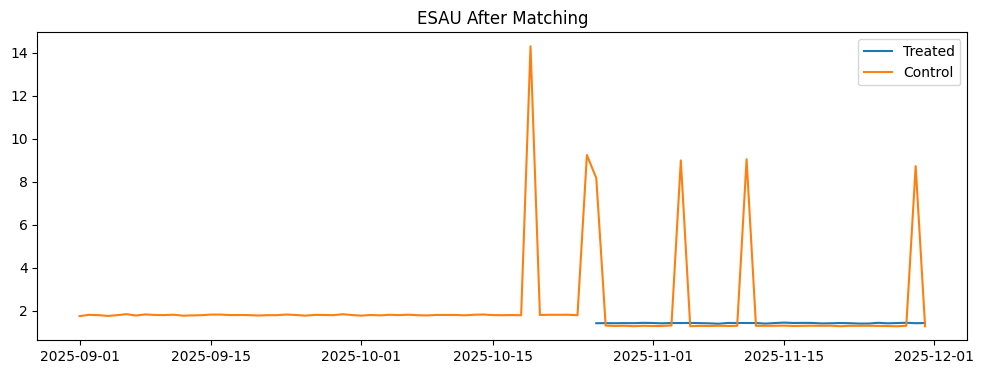

In [84]:
plt.figure(figsize=(12,4))
plt.plot(esau_treated, label="Treated")
plt.plot(esau_control, label="Control")
plt.legend()
plt.title("ESAU After Matching")
plt.show()


In [85]:
events['date'] = pd.to_datetime(events['date'])

In [86]:
events_cal = events.merge(calendar_effects, left_on="date", right_on="date")


In [87]:
esau_by_cohort = (
    matched_events
    .merge(users[["user_id","cohort_quality"]], on="user_id")
    .groupby(["date","cohort_quality"])
    .size()
)


In [88]:
returning = matched_events[matched_events["is_returning"] == True]


In [91]:
users.head()



,user_id,signup_date,country,cohort_quality,acquisition_channel
0,1,2025-10-22,US,high,referral
1,2,2025-09-15,US,high,referral
2,3,2025-11-11,US,low,paid
3,4,2025-10-31,US,low,affiliate
4,5,2025-09-21,US,high,organic


In [90]:
events.head()

,user_id,event_time,event_name,feature_exposed,first_seen,is_returning,date,post,treated
0,1,2025-10-22 18:11:00,session_start,0,2025-10-22 13:53:00,False,2025-10-22,0,0
1,1,2025-10-22 13:53:00,session_start,0,2025-10-22 13:53:00,False,2025-10-22,0,0
2,1,2025-10-25 11:17:00,session_start,0,2025-10-22 13:53:00,False,2025-10-25,0,0
3,1,2025-10-25 05:26:00,session_start,0,2025-10-22 13:53:00,False,2025-10-25,0,0
4,1,2025-10-27 22:08:00,session_start,1,2025-10-22 13:53:00,False,2025-10-27,1,1


In [92]:
esau_treated_mean = esau_treated.mean()
esau_control_mean = esau_control.mean()

esau_treated_mean, esau_control_mean


(np.float64(1.4122606396097914), np.float64(2.1353098821583627))

In [93]:
(esau_treated_mean - esau_control_mean)


np.float64(-0.7230492425485713)

In [96]:
post_matched = matched_events[matched_events["post"] == 1]

treated_post = post_matched[post_matched["treated_x"] == 1]
control_post = post_matched[post_matched["treated_x"] == 0]

treated_esau = (
    treated_post.shape[0] /
    treated_post["user_id"].nunique()
)

control_esau = (
    control_post.shape[0] /
    control_post["user_id"].nunique()
)

treated_esau, control_esau, treated_esau - control_esau


(8.676188475810404, 10.180172565592533, -1.5039840897821293)

In [97]:
relative_effect_pct = (
    (control_esau - treated_esau) / control_esau
) * 100
relative_effect_pct


14.773660073949744

In [101]:
trend_df = (
    did_df
    .groupby(["date", "treated"])
    .agg(esau=("esau", "mean"))
    .reset_index()
)


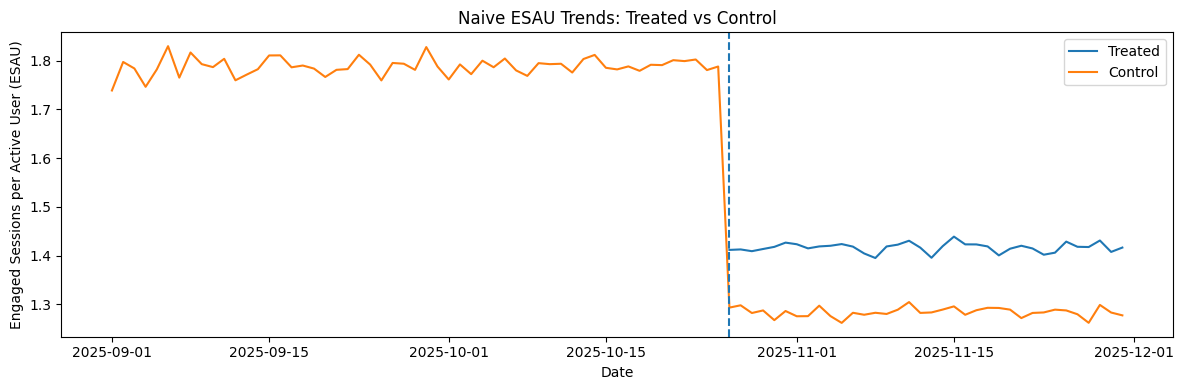

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.plot(
    trend_df[trend_df["treated"] == 1]["date"],
    trend_df[trend_df["treated"] == 1]["esau"],
    label="Treated",
)

plt.plot(
    trend_df[trend_df["treated"] == 0]["date"],
    trend_df[trend_df["treated"] == 0]["esau"],
    label="Control",
)

# Feature launch marker
plt.axvline(feature_launch, linestyle="--")

plt.title("Naive ESAU Trends: Treated vs Control")
plt.xlabel("Date")
plt.ylabel("Engaged Sessions per Active User (ESAU)")
plt.legend()
plt.tight_layout()
plt.show()


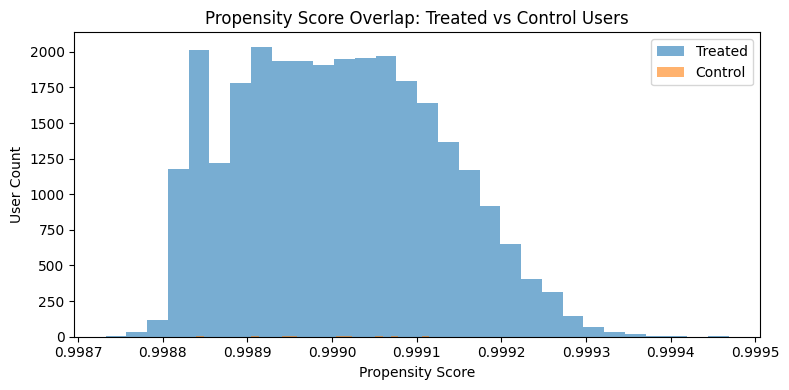

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.hist(
    user_features[user_features["treated"] == 1]["propensity"],
    bins=30,
    alpha=0.6,
    label="Treated"
)

plt.hist(
    user_features[user_features["treated"] == 0]["propensity"],
    bins=30,
    alpha=0.6,
    label="Control"
)

plt.title("Propensity Score Overlap: Treated vs Control Users")
plt.xlabel("Propensity Score")
plt.ylabel("User Count")
plt.legend()
plt.tight_layout()
plt.show()


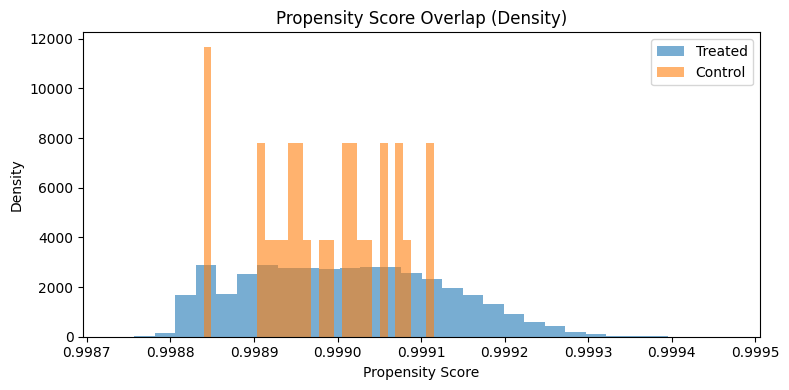

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.hist(
    user_features[user_features["treated"] == 1]["propensity"],
    bins=30,
    density=True,
    alpha=0.6,
    label="Treated"
)

plt.hist(
    user_features[user_features["treated"] == 0]["propensity"],
    bins=30,
    density=True,
    alpha=0.6,
    label="Control"
)

plt.title("Propensity Score Overlap (Density)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
